# Multi-Head attention

1. Visualization of attention matrices $Q\cdot K^T$
2. Analysis of matrix symmetry

In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Visualization of attention matrices

/Users/miriamzara/LCP_B_GPT2/my_venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(
/Users/miriamzara/LCP_B_GPT2/my_venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


Prompt: The italian flag's colors are red, white and

Layer  1: Entropy = 0.0345
   1:       Ġthe (0.9970)
   2:         Ġa (0.0018)
   3:          / (0.0006)
   4:         Ġ" (0.0002)
   5:         ĠI (0.0001)
   6:      Ġthen (0.0001)
   7:     Ġother (0.0001)
   8:          , (0.0000)
   9:        Ġin (0.0000)
  10:       Ġand (0.0000)
  11:          Ċ (0.0000)
  12:        Ġis (0.0000)
  13:        Ġan (0.0000)
  14:          - (0.0000)
  15:        Ġit (0.0000)
Layer  2: Entropy = 0.9767
   1:       Ġthe (0.8089)
   2:          / (0.0964)
   3:      Ġthen (0.0772)
   4:     Ġother (0.0147)
   5:         Ġa (0.0015)
   6:         ĠI (0.0010)
   7:         Ġ" (0.0001)
   8:  Ġpossibly (0.0001)
   9:        Ġso (0.0000)
  10:      Ġeven (0.0000)
  11:          , (0.0000)
  12:        Ġit (0.0000)
  13:        Ġin (0.0000)
  14:        Ġan (0.0000)
  15:        Ġis (0.0000)
Layer  3: Entropy = 0.7119
   1:       Ġthe (0.8669)
   2:          / (0.0912)
   3:      Ġthen (0.0374)
   4:  

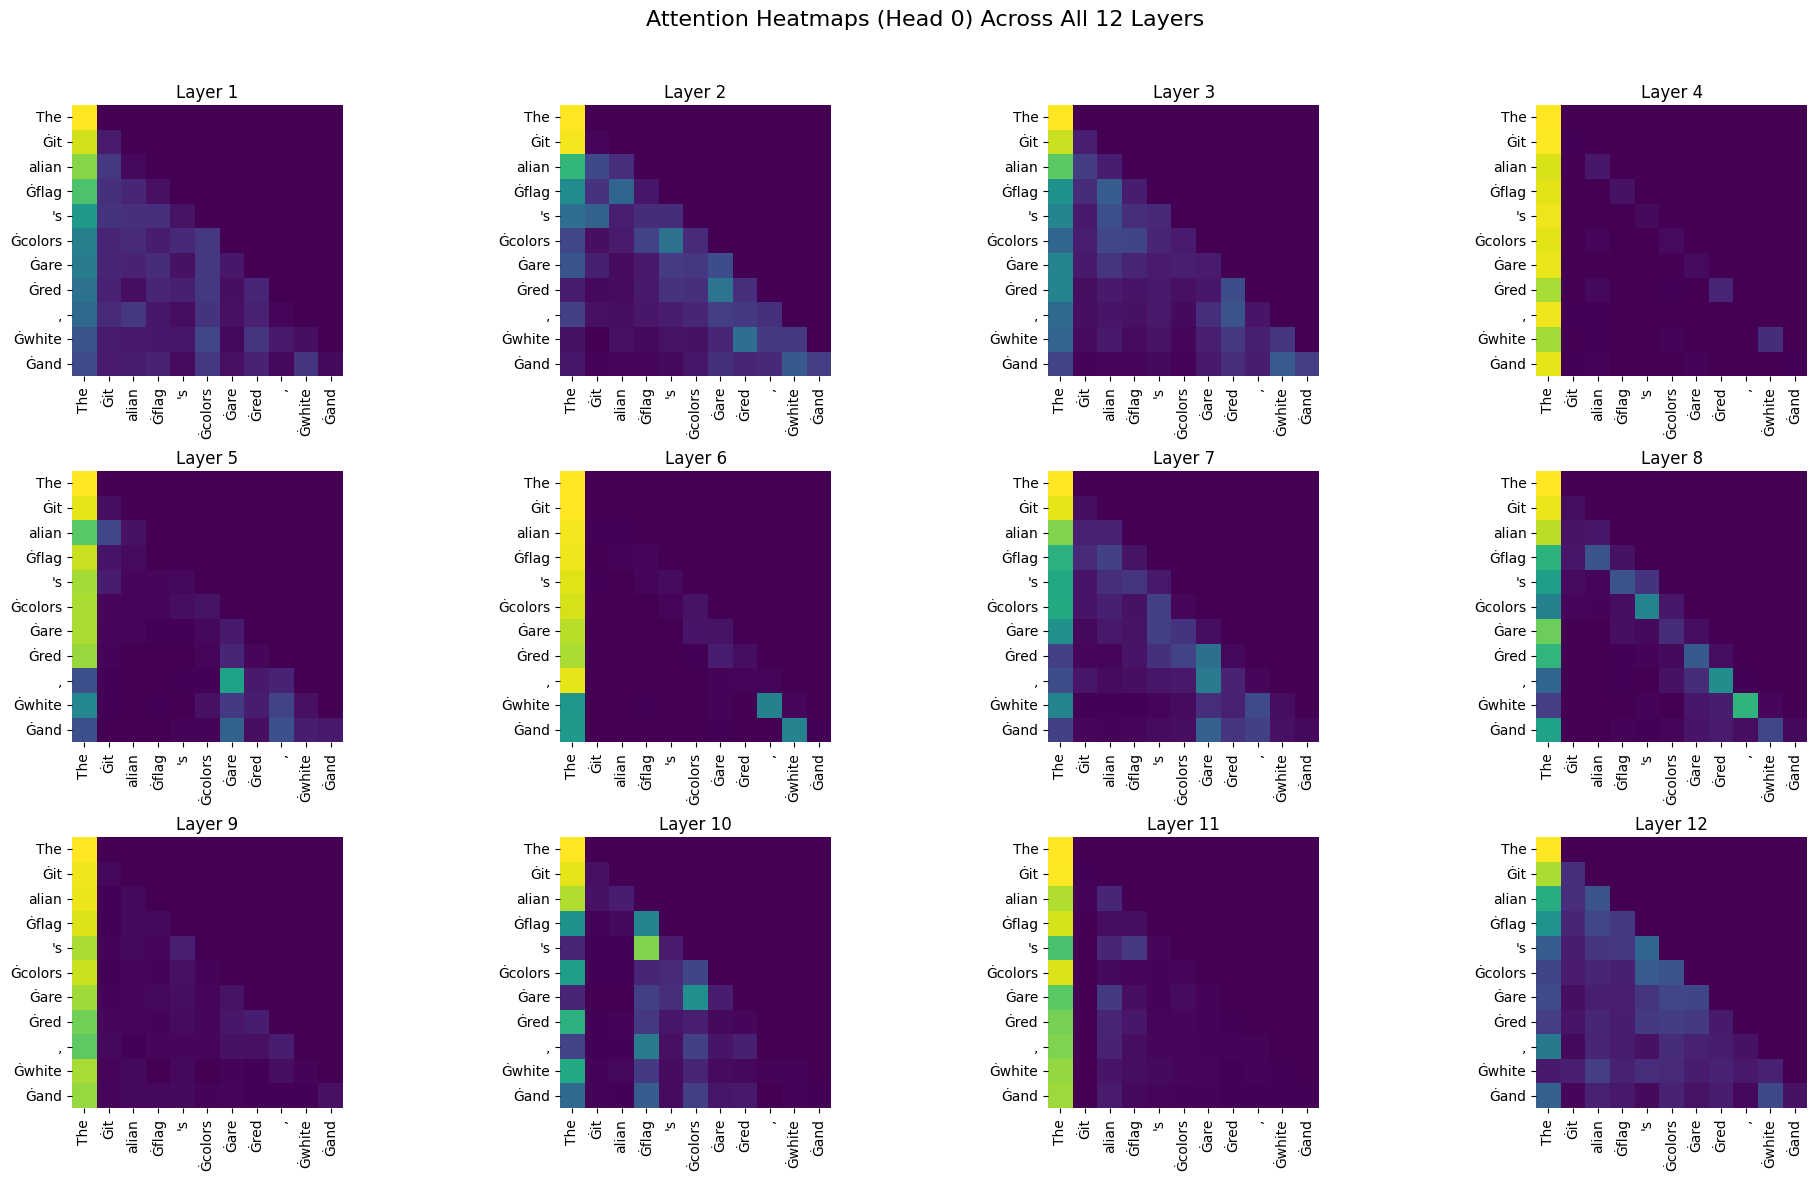

In [ ]:
model = AutoModelForCausalLM.from_pretrained("gpt2", output_attentions=True, output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained("gpt2")                     #trasforma input in token
model.eval() # set in evaluation mode (no dropout)

# Input text
prompt = "The italian flag's colors are red, white and"
inputs = tokenizer(prompt, return_tensors="pt")
input_ids = inputs["input_ids"]
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

# Forward pass with hidden states
with torch.no_grad():
    outputs = model(**inputs)

attentions = outputs.attentions  # List of tensors: [layer][batch, head, seq_len, seq_len], head = Et

hidden_states = outputs.hidden_states  # Tuple: (embeddings + 12 layers), hidden_states = each "line" (1dim of a tensor) è X_seq
n_layers = len(hidden_states)

# Language modeling head
lm_head = model.lm_head  # Linear layer from hidden dim -> vocab size
top_k = 15  # Change as needed
token_position = -1  # Last token in prompt

print(f"Prompt: {prompt}\n")

for i in range(1, n_layers):  # skip embeddings (index 0)
    hidden = hidden_states[i]  # shape: [1, seq_len, hidden_dim]
    last_token_vec = hidden[0, token_position, :]  # shape: [hidden_dim]
    logits = lm_head(last_token_vec)  # shape: [vocab_size]
    probs = torch.softmax(logits, dim=-1)

    # Avoid log(0) by masking zero probabilities -> else you get 0*-inf = nan when probs are zero
    mask = probs > 0
    entropy = -torch.sum(probs[mask] * torch.log2(probs[mask])).item()

    top_probs, top_ids = torch.topk(probs, top_k)
    top_tokens = tokenizer.convert_ids_to_tokens(top_ids)

    print(f"Layer {i:2d}: Entropy = {entropy:.4f}")
    for j in range(top_k):
        print(f"  {j+1:2d}: {top_tokens[j]:>10} ({top_probs[j].item():.4f})")

def plot_attention_layers(attentions, tokens, head_idx=0):
    num_layers = len(attentions)
    
    fig, axes = plt.subplots(3, 4, figsize=(20, 12))
    fig.suptitle(f"Attention Heatmaps (Head {head_idx}) Across All 12 Layers", fontsize=16)

    for i in range(num_layers):
        ax = axes[i // 4, i % 4]
        attn = attentions[i][0, head_idx, :, :].detach().numpy()
        sns.heatmap(attn, xticklabels=tokens, yticklabels=tokens, cmap="viridis", ax=ax, square=True, cbar=False)
        ax.set_title(f"Layer {i+1}")
        ax.tick_params(axis='x', rotation=90)
        ax.tick_params(axis='y', rotation=0)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Call function
plot_attention_layers(attentions, tokens, head_idx=0)

### Multi-head Attention Matrices


$$ Q\cdot K^T = X\,(W_Q \cdot W_K^T)\,X^T$$
Here we search for a possible mathematical interpretation of the linear transformations involved in the computation of $Q, K, V$ in multi-head attention. Specifically, we want to answer the following questions:


In single head attention:

- how different is the matrix $W_Q \cdot W_K^T$ from the identity matrix? If we find a significative difference, it means that the attention is doing something more than $X\cdot X^T$ - i.e. the projection of the buffer on itself;

- is $W_Q \cdot W_K^T$ symmetric? In that case, the attention weights can be seen as $X' \cdot X'^T$ where $X' = A\cdot X$.

In [5]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load pretrained model
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [3]:
state_dict = model.state_dict()
for name, weights in state_dict.items():
    print(name, weights.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

### Attention matrices


1 - Transformation to queries, keys, values. Matrices are stacked together horizontally (column- wise). This way, only 1 matrix multiplication is required instead of 3.
$$
\begin{align}
    [Q, K, V] &= X \cdot [W_Q, W_K, W_V] + 
    \begin{pmatrix}
        \text{bias QKV} \\
        \cdots \\
        \text{bias QKV}
    \end{pmatrix} \\
    (N \cdot 3D) &= (N \cdot D) \cdot (D \cdot 3D) + (N \cdot 3D)
\end{align}
$$
2 - Splitting into heads:

$ \begin{align}
    Q &\rightarrow [Q_1, \cdots, Q_{n_H}] \\
    (N \cdot D) &=  \text{list of}\,\, (N \cdot d_K)  \\
\end{align}
$

3 - Attention computation:
$ \begin{align}
    \text{head h} &= \text{softmax}\left( \frac{Q_h\cdot K_h^T}{\sqrt{d_K} } \right) [Q_1, \cdots, Q_{n_H}] \\
    (N \cdot D) &=  \text{list of}\,\, (N \cdot d_K)  
\end{align}
$

4 - Backwards projection

$
\begin{align}
Y &= [\text{head 1},\, \text{head 2} \cdots \text{head nH}] \cdot W_0 + 
    \begin{pmatrix}
        \text{bias 0 } \\
        \cdots \\
        \text{bias 0}
    \end{pmatrix} \\
    (N\cdot D) &= (N \cdot D) \cdot (D\cdot D) + (N \cdot D) \\
\end{align}
$

In [8]:
layer_max = 12
qkv_weights = [state_dict[f"transformer.h.{i}.attn.c_attn.weight"].cpu().detach().numpy() for i in range(0, layer_max)] # list of N x (3D) matrices
qkv_biases = [state_dict[f"transformer.h.{i}.attn.c_attn.bias"].cpu().detach().numpy() for i in range(0, layer_max)] # list of D x 1 vectors
projection_weights = [state_dict[f"transformer.h.{i}.attn.c_proj.weight"].cpu().detach().numpy() for i in range(0, layer_max)] # list of D x D matrices
projection_biases = [state_dict[f"transformer.h.{i}.attn.c_proj.bias"].cpu().detach().numpy() for i in range(0, layer_max)] # list of D x 1 vectors
print(qkv_weights[0].shape)
print(qkv_biases[0].shape)
print(projection_weights[0].shape)
print(projection_biases[0].shape)

(768, 2304)
(2304,)
(768, 768)
(768,)


In [9]:
D = 768
q_weights = [qkv_weights[i][:,0:D] for i in range(0, layer_max)]
k_weights = [qkv_weights[i][:,D:(2*D)] for i in range(0, layer_max)]
qkt_weights = [np.matmul(q_weights[i], k_weights[i].T) for i in range(0, layer_max)]

/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_8185/835126048.py:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[2].legend()


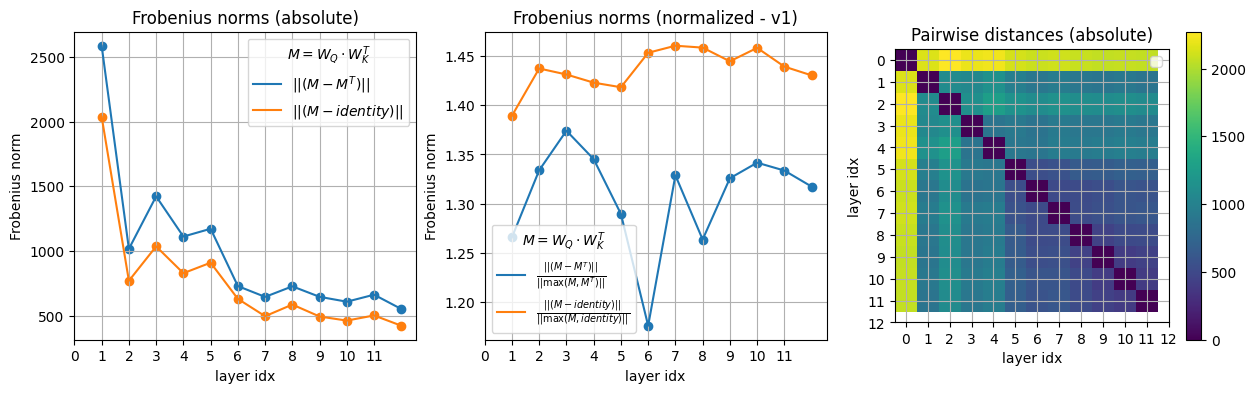

In [11]:
from numpy.linalg import norm
import matplotlib.pyplot as plt

# Symmetric?  Distance of QKt - (QKt)t from the null matrix
distances_symm = [norm(qkt_weights[i] - qkt_weights[i].T, ord = "fro") for i in range(0, layer_max)]
# normalization -v1
maximum_symmetric_norms = [norm(np.maximum(qkt_weights[i], qkt_weights[i].T), ord = "fro") for i in range(layer_max)]
distances_symm_normalized = [distances_symm[i]/maximum_symmetric_norms[i] for i in range(0, layer_max)]



# Difference from the identiy matrix ?
maximum_identity_norms = [norm(np.maximum(qkt_weights[i], np.eye(D)), ord = "fro") for i in range(layer_max)]
distances_identity = [norm(qkt_weights[i] - np.eye(D), ord = "fro") for i in range(0, layer_max)]
distances_identity_normalized = [distances_identity[i]/maximum_identity_norms[i] for i in range(0, layer_max)]


fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (15,4))
plt.subplots_adjust(hspace = 0.3)


axs[0].plot(np.arange(1, layer_max + 1), distances_symm, label = r"$||(M - M^T)||$")
axs[0].scatter(np.arange(1, layer_max + 1), distances_symm)
axs[0].plot(np.arange(1, layer_max + 1), distances_identity, label = r"$||(M - identity)||$")
axs[0].scatter(np.arange(1, layer_max + 1), distances_identity)
axs[0].grid()
axs[0].set_title("Frobenius norms (absolute)")
axs[0].set_xlabel("layer idx")
axs[0].set_ylabel("Frobenius norm")
axs[0].set_xticks(np.arange(0, 12))
axs[0].legend(title = r"$M = W_Q\cdot W_K^T$")

axs[1].plot(np.arange(1, layer_max + 1), distances_symm_normalized, label = r"$\frac{||(M - M^T)||}{||\text{max}(M, M^T)||}$")
axs[1].scatter(np.arange(1, layer_max + 1), distances_symm_normalized)
axs[1].plot(np.arange(1, layer_max + 1), distances_identity_normalized, label = r"$\frac{||(M - identity)||}{||\text{max}(M, identity)||}$")
axs[1].scatter(np.arange(1, layer_max + 1), distances_identity_normalized)
axs[1].grid()
axs[1].set_title("Frobenius norms (normalized - v1)")
axs[1].set_xlabel("layer idx")
axs[1].set_ylabel("Frobenius norm")
axs[1].set_xticks(np.arange(0, 12))
axs[1].legend(title = r"$M = W_Q\cdot W_K^T$")


distances_pairwise = [[norm(qkt_weights[i] - qkt_weights[j]) for j in range(0, layer_max)] for i in range(0, layer_max)]


im = axs[2].imshow(distances_pairwise)
fig.colorbar(im, ax=axs[2])
axs[2].grid()
axs[2].set_title("Pairwise distances (absolute)")
axs[2].set_xticks(np.arange(0, 13))
axs[2].set_yticks(np.arange(0, 13))
axs[2].set_xlabel("layer idx")
axs[2].set_ylabel("layer idx")
axs[2].legend()

### Checking other normalizations

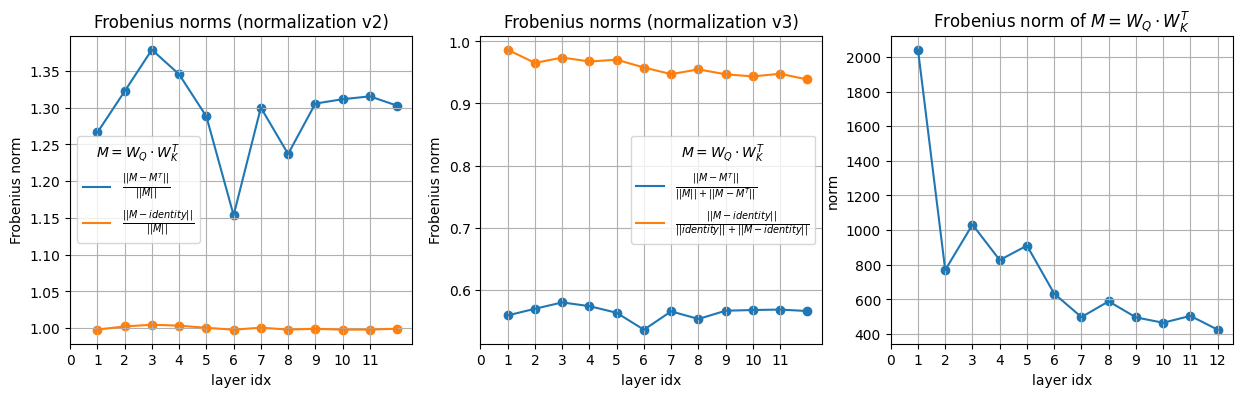

In [16]:
# normalization -v2
distances_symm_normalized_2 = [distances_symm[i]/norm(qkt_weights[i]) for i in range(0, layer_max)]
distances_identity_normalized_2 = [distances_identity[i]/norm(qkt_weights[i]) for i in range(0, layer_max)]

# normalization -v3 ()
distances_symm_normalized_3 = [distances_symm[i]/(norm(qkt_weights[i]) + distances_symm[i]) for i in range(0, layer_max)]
distances_identity_normalized_3 = [distances_identity[i]/(norm(np.eye(D)) + distances_identity[i]) for i in range(0, layer_max)]

# norm of M itself
M_norm = [norm(qkt_weights[i]) for i in range(0, layer_max)]


fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (15,4))
plt.subplots_adjust(hspace = 0.3)


axs[0].plot(np.arange(1, layer_max + 1), distances_symm_normalized_2, label = r"$\frac{||M- M^T||}{||M||}$")
axs[0].scatter(np.arange(1, layer_max + 1), distances_symm_normalized_2)
axs[0].plot(np.arange(1, layer_max + 1), distances_identity_normalized_2, label = r"$\frac{||M- identity||}{||M||}$")
axs[0].scatter(np.arange(1, layer_max + 1), distances_identity_normalized_2)
axs[0].grid()
axs[0].set_title("Frobenius norms (normalization v2)")
axs[0].set_xlabel("layer idx")
axs[0].set_ylabel("Frobenius norm")
axs[0].set_xticks(np.arange(0, 12))
axs[0].legend(title = r"$M = W_Q\cdot W_K^T$")



axs[1].plot(np.arange(1, layer_max + 1), distances_symm_normalized_3, label = r"$\frac{||M- M^T||}{||M|| + ||M - M^T||}$")
axs[1].scatter(np.arange(1, layer_max + 1), distances_symm_normalized_3)
axs[1].plot(np.arange(1, layer_max + 1), distances_identity_normalized_3, label = r"$\frac{||M- identity||}{||identity|| + ||M - identity||}$")
axs[1].scatter(np.arange(1, layer_max + 1), distances_identity_normalized_3)
axs[1].grid()
axs[1].set_title("Frobenius norms (normalization v3)")
axs[1].set_xlabel("layer idx")
axs[1].set_ylabel("Frobenius norm")
axs[1].set_xticks(np.arange(0, 12))
axs[1].legend(title = r"$M = W_Q\cdot W_K^T$")


axs[2].plot(np.arange(1, layer_max + 1), M_norm)
axs[2].scatter(np.arange(1, layer_max + 1), M_norm)
axs[2].set_xlabel("layer idx")
axs[2].set_ylabel("norm")
axs[2].set_title(r"Frobenius norm of $M = W_Q\cdot W_K^T$")
axs[2].set_xticks(np.arange(0, 13))
axs[2].grid()

### 3. Computing ranks of the transformation matrices.

$W_Q, W_K, W_V, W_0$ : are they projections or change of basis?


Do they preserve distances? Do they preserve angles?

In [10]:
layer_max = 12
qkv_weights = [state_dict[f"transformer.h.{i}.attn.c_attn.weight"].cpu().detach().numpy() for i in range(0, layer_max)] # list of N x (3D) matrices
qkv_biases = [state_dict[f"transformer.h.{i}.attn.c_attn.bias"].cpu().detach().numpy() for i in range(0, layer_max)] # list of D x 1 vectors
projection_weights = [state_dict[f"transformer.h.{i}.attn.c_proj.weight"].cpu().detach().numpy() for i in range(0, layer_max)] # list of D x D matrices
projection_biases = [state_dict[f"transformer.h.{i}.attn.c_proj.bias"].cpu().detach().numpy() for i in range(0, layer_max)] # list of D x 1 vectors
print(qkv_weights[0].shape)
print(qkv_biases[0].shape)
print(projection_weights[0].shape)
print(projection_biases[0].shape)


D = 768
q_weights = [qkv_weights[i][:,0:D] for i in range(0, layer_max)]
k_weights = [qkv_weights[i][:,D:(2*D)] for i in range(0, layer_max)]
v_weights = [qkv_weights[i][:, (2*D):(3*D)] for i in range(0, layer_max)]
w0_weights = projection_weights

print(q_weights[0].shape)
print(k_weights[0].shape)
print(v_weights[0].shape)
print(w0_weights[0].shape)

(768, 2304)
(2304,)
(768, 768)
(768,)
(768, 768)
(768, 768)
(768, 768)
(768, 768)


In [ ]:
import numpy as np

q_rank = [np.linalg.matrix_rank(q) for q in q_weights]
k_rank = [np.linalg.matrix_rank(k) for k in k_weights]
v_rank = [np.linalg.matrix_rank(v) for v in v_weights]
w0_rank = [np.linalg.matrix_rank(w0) for w0 in w0_weights]

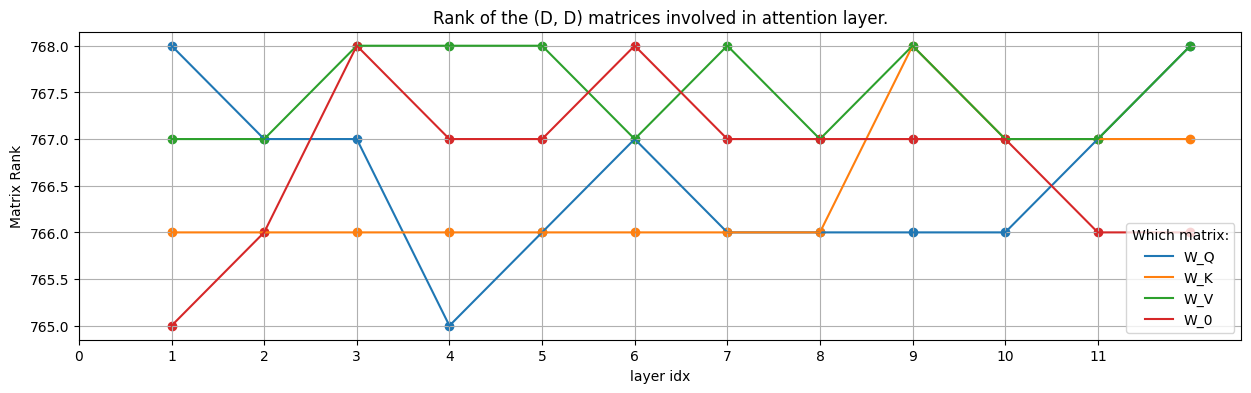

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (15,4))


axs.plot(np.arange(1, layer_max + 1), q_rank, label = "W_Q")
axs.scatter(np.arange(1, layer_max + 1), q_rank)

axs.plot(np.arange(1, layer_max + 1), k_rank, label = "W_K")
axs.scatter(np.arange(1, layer_max + 1), k_rank)

axs.plot(np.arange(1, layer_max + 1), v_rank, label = "W_V")
axs.scatter(np.arange(1, layer_max + 1), v_rank)

axs.plot(np.arange(1, layer_max + 1), w0_rank, label = "W_0")
axs.scatter(np.arange(1, layer_max + 1), w0_rank)



axs.grid()
axs.set_title("Rank of the (D, D) matrices involved in attention layer.")
axs.set_xlabel("layer idx")
axs.set_ylabel("Matrix Rank")
axs.set_xticks(np.arange(0, 12))

axs.legend(title = "Which matrix:")

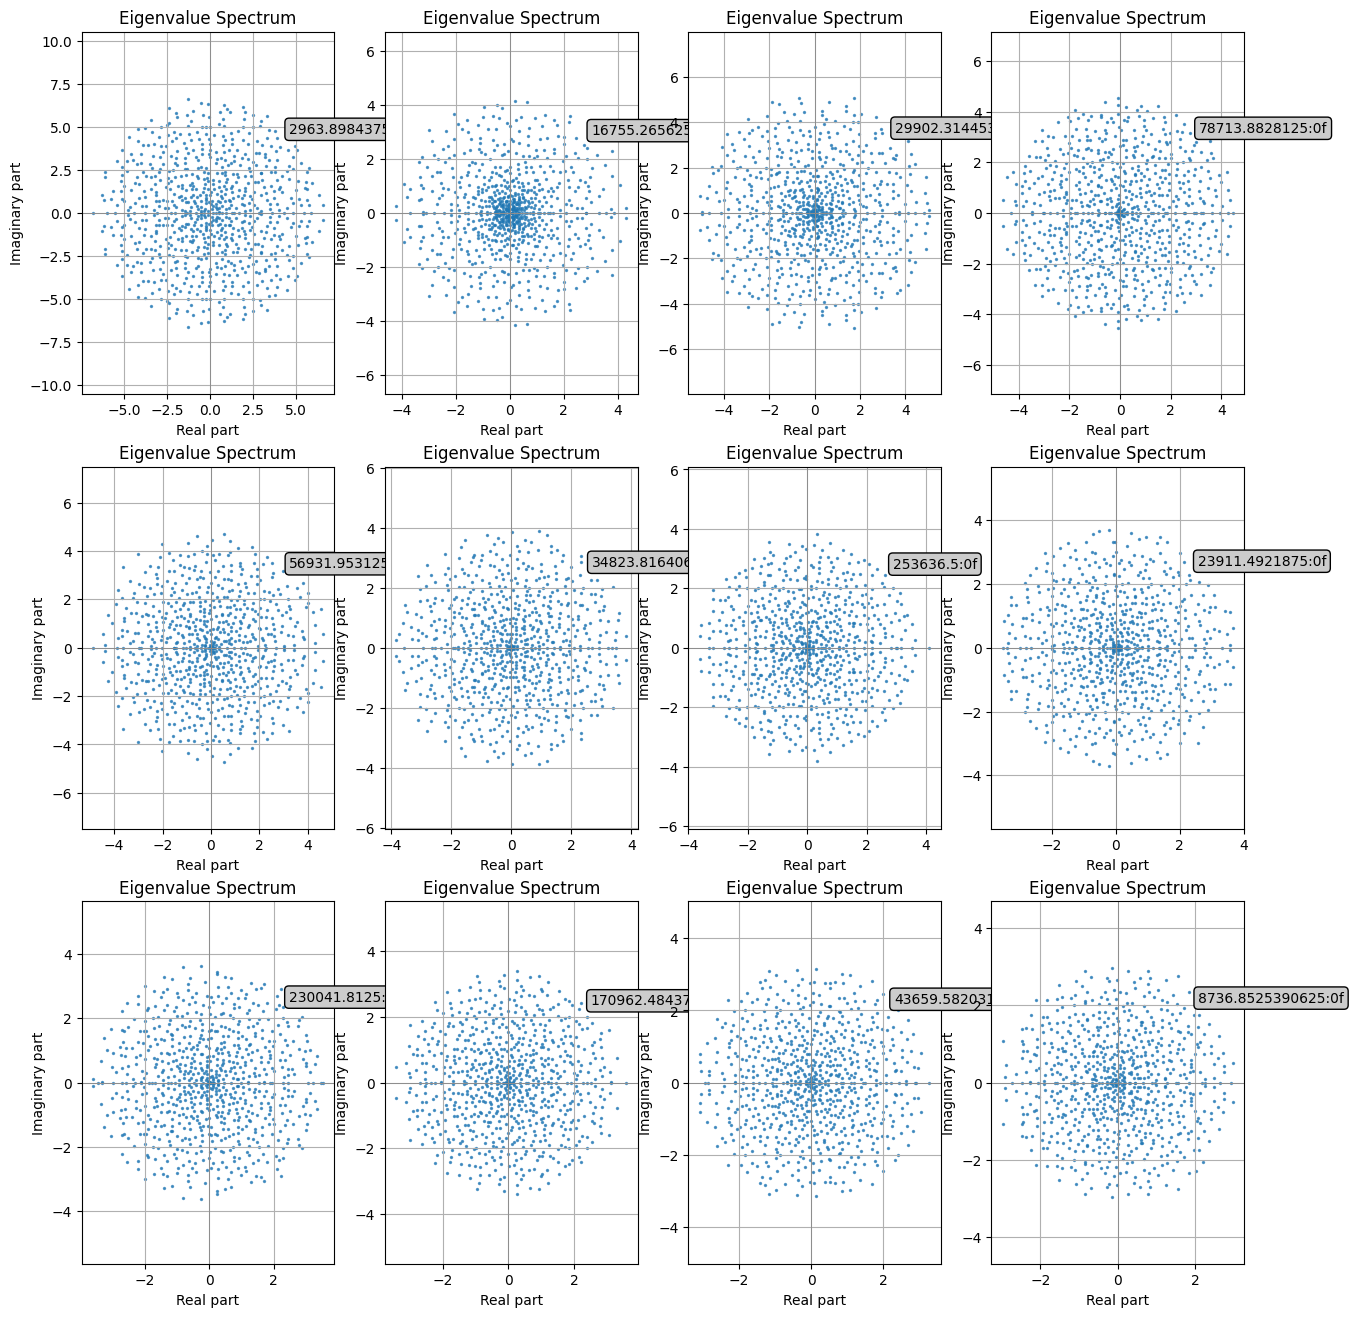

In [37]:
fig, axs = plt.subplots(nrows = 3, ncols = 4, figsize=(5*3,4*4))
axs = axs.flatten()

bbox = dict(boxstyle="round", fc="0.8")

for i in range(0, layer_max):

    A = q_weights[i]
    eigvals = np.linalg.eigvals(A)
    cond_number = np.linalg.cond(A)
    axs[i].annotate(text= f"{cond_number}:0f", xy = (max(eigvals.real)*0.7, max(eigvals.imag)*0.7), bbox = bbox)
    axs[i].scatter(eigvals.real, eigvals.imag, s=2, alpha=0.7)
    axs[i].axhline(0, color='gray', linewidth=0.5)
    axs[i].axvline(0, color='gray', linewidth=0.5)
    axs[i].set_xlabel('Real part')
    axs[i].set_ylabel('Imaginary part')
    axs[i].set_title('Eigenvalue Spectrum')
    axs[i].grid(True)
    axs[i].axis('equal')


You’re likely observing:
- A linear transformation that scrambles the space, mixing directions with complex shearing, non-uniform scaling, and non-normal behavior.
- The fact that eigenvalues are inside a disk (not just on the unit circle) means it compresses some directions (i.e., not volume-preserving).

So: the circle is not a “structured” geometric transformation like rotation or scaling — it’s a signature of randomness and loss of geometric meaning.

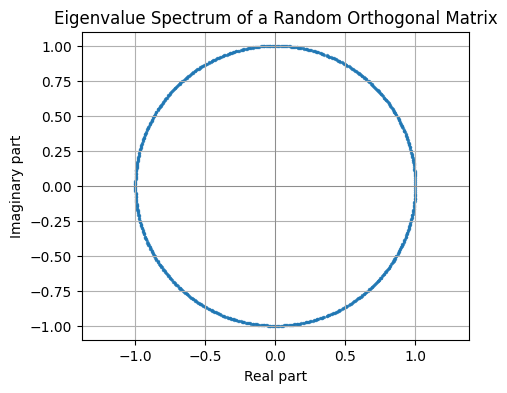

In [29]:

# Step 1: Generate a random matrix
A = np.random.randn(789, 789)
Q, R = np.linalg.qr(A)
# Q is now orthogonal: Q.T @ Q ≈ I
eigvals = np.linalg.eigvals(Q)

plt.figure(figsize=(5,4))
plt.scatter(eigvals.real, eigvals.imag, s=2, alpha=0.7)
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.title('Eigenvalue Spectrum of a Random Orthogonal Matrix')
plt.grid(True)
plt.axis('equal')
plt.show()

Is A orthogonal? False
Condition number: 2963.8984


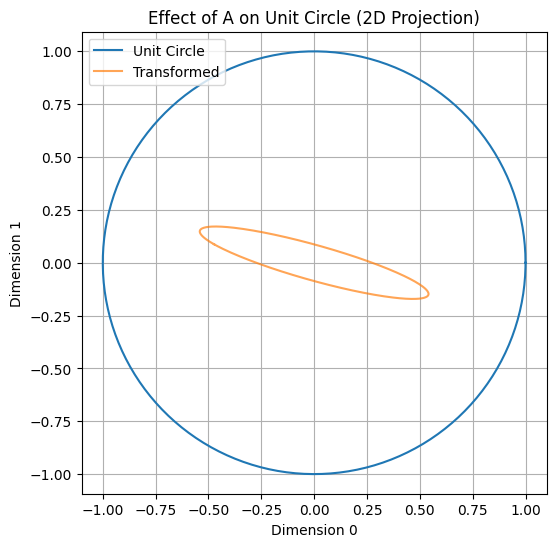

In [31]:
A = q_weights[0]
n = A.shape[0]
# 1. ✅ Check if A is orthogonal
is_orthogonal = np.allclose(A.T @ A, np.eye(n), atol=1e-6)
print("Is A orthogonal?", is_orthogonal)

# 2. ✅ Condition number (ratio of largest to smallest singular value)
cond_number = np.linalg.cond(A)
print("Condition number:", cond_number)

# 3. ✅ Visualize transformation of unit sphere

# Pick a 2D plane (e.g. first 2 dimensions)
dim1, dim2 = 0, 1
num_points = 300

# Generate points on unit circle in 2D subspace
theta = np.linspace(0, 2*np.pi, num_points)
unit_circle = np.zeros((n, num_points))
unit_circle[dim1, :] = np.cos(theta)
unit_circle[dim2, :] = np.sin(theta)

# Transform the circle with A
transformed = A @ unit_circle

# Plot
plt.figure(figsize=(6,6))
plt.plot(unit_circle[dim1], unit_circle[dim2], label='Unit Circle')
plt.plot(transformed[dim1], transformed[dim2], label='Transformed', alpha=0.7)
plt.xlabel(f"Dimension {dim1}")
plt.ylabel(f"Dimension {dim2}")
plt.title("Effect of A on Unit Circle (2D Projection)")
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

📈 Condition number ≈ 2964 (not terrible, but not great)
	•	This measures how much the matrix distorts space.
	•	A condition number ≈ 1 means near-orthogonal (ideal).
	•	Your value suggests some directions are stretched ~3000× more than others, but it’s not catastrophic (e.g., not 10^8).

📐 Transformed unit circle = ellipse
	•	Confirms that some directions are amplified, others are compressed.
	•	Geometrically, your matrix is a non-uniform linear transformation — likely combining rotation + anisotropic scaling.

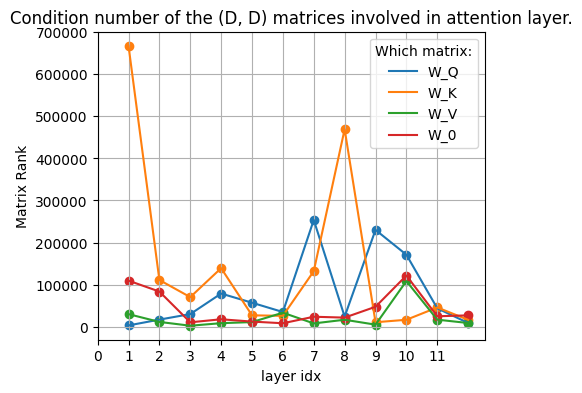

In [39]:
q_number = [np.linalg.cond(A) for A in q_weights]
k_number = [np.linalg.cond(A) for A in k_weights]
v_number = [np.linalg.cond(A) for A in v_weights]
w0_number = [np.linalg.cond(A) for A in w0_weights]



fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(5, 4))




axs.plot(np.arange(1, layer_max + 1), q_number, label = "W_Q")
axs.scatter(np.arange(1, layer_max + 1), q_number)

axs.plot(np.arange(1, layer_max + 1), k_number, label = "W_K")
axs.scatter(np.arange(1, layer_max + 1), k_number)

axs.plot(np.arange(1, layer_max + 1), v_number, label = "W_V")
axs.scatter(np.arange(1, layer_max + 1), v_number)

axs.plot(np.arange(1, layer_max + 1), w0_number, label = "W_0")
axs.scatter(np.arange(1, layer_max + 1), w0_number)



axs.grid()
axs.set_title("Condition number of the (D, D) matrices involved in attention layer.")
axs.set_xlabel("layer idx")
axs.set_ylabel("Matrix Rank")
axs.set_xticks(np.arange(0, 12))

axs.legend(title = "Which matrix:")

🧠 What does this mean?

A condition number ≈ 10^5 means:
	•	W_Q stretches some directions 100,000× more than others
	•	It is very sensitive to input perturbations in X
	•	In geometric terms: the input space is squashed along some directions and exploded along others

⸻

🧬 Why does this matter for attention?

1. Q = X·W_Q projects inputs into “query space”
	•	A poorly conditioned W_Q means:
	•	Small variations in X may lead to large or unstable differences in Q
	•	Some directions in the input are essentially ignored (near-zero amplification)
	•	Others dominate (over-amplified)
